In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 10]

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE, MDS
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import warnings 
warnings.filterwarnings('ignore')

def preprocess(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

In [3]:
# load and randomize

yelps = pd.read_csv('sentiment/yelps.csv').sample(frac=1.)
movies = pd.read_csv('sentiment/movies.csv').sample(frac=1.)

## Inspecting p(X) of the BOW vectorizers

Assuming that our data consists of discrete features, as in the Bag of Words models we have seen so far, visualizing $p(X)$ consists of visualizing the PMF of a multionomial distribution that consists of all the features in our data. 

Of course, this is a very wide distribution, even if we just include unigrams. 

Thus, we will visualize just the most popular features. 

We will see how, given the most popular features of one dataset, the other dataset compares. 

In [4]:
from copy import deepcopy

def _train_and_transform(vectorizer, X):
    vectorizer.fit(X)
    return vectorizer, vectorizer.transform(X)

def compare(vectorizer, A, B):
    vec_A, VA = _train_and_transform(deepcopy(vectorizer), A) 
    vec_B, VB = _train_and_transform(deepcopy(vectorizer), B) 

    # Get the most popular words for A
    # ignoring the top 25 super common
    # words
    sums = np.array(VA.sum(0)).reshape(-1)
    tops = np.argsort(sums)[-325:-25]
    freqs_A = sums[tops]

    features = np.array(vec_A.get_feature_names())[tops]

    idxs = np.array([vec_B.vocabulary_.get(s) for s in features])
    sums = np.array(VB.sum(0)).reshape(-1)
    freqs_B = [sums[i] if i else 0. for i in idxs]

    return pd.concat([pd.DataFrame({ 'word': features, 'dataset': d, 'freq': f }) 
                      for d,f in [('A',freqs_A), ('B',freqs_B)]])

In [5]:
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 1, use_idf=False)
df = compare(vectorizer, yelps.sample(500).text, movies.sample(500).text)

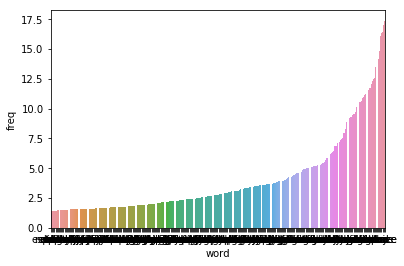

In [6]:
sns.barplot(x = 'word', 
            y = 'freq', 
            data = df[df.dataset == 'A'])

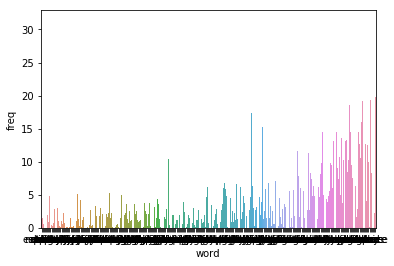

In [7]:
sns.barplot(x = 'word', 
            y = 'freq', 
            data = df[df.dataset == 'B'])

## Generative vs. Discriminative

Play around with the following plotting function. Is this consisten with the theoretical results of Ng and Jordan? Can you get the opposite results? Why? 

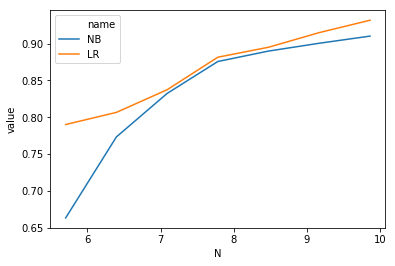

In [8]:
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 20, use_idf=False)
V = vectorizer.fit_transform(yelps.text)
y = yelps.positive

def _cv_score(V, y, models):
    return [{ 'name': name, 'value': np.mean(cross_val_score(model, V, y, cv=3)) }
            for name, model in models]

def plot_cv_scores(V, y, models, ticks):
    scores = [_cv_score(V[:t], y[:t], models) for t in ticks]        
    scores = [({'N': np.log(t) , **i}) for t,s 
              in zip(ticks, scores) for i in s]
    df = pd.DataFrame(scores)
    return sns.lineplot(y='value', x='N', hue='name', data=df)

models = [('NB', MultinomialNB(fit_prior=False)), 
          ('LR', LogisticRegression())]

plot_cv_scores(V, y, models, [300, 600, 1200, 2400, 4800, 9600, 19200])

## Searching the Grid

Hyperparameter tuning, in its simplest form, can be done via a grid search. 

We can use cross validation to estimate the out-of-sample expected risk. 

SKlearn gives us a very nice package for this: GridSearchCV

The API can be a bit complicated at first glance, but it's simple once you get used to it and comfortable with the idea of a "pipeline". 

In [9]:
#Import some stuff
from sklearn.model_selection import GridSearchCV
from sklearn import svm

#Set up GridSearchCV for MultinomialNB
params_nb           = {'alpha' : np.arange(0,1,0.1),'fit_prior': [True, False]}
classifier_nb       = MultinomialNB()
cv_nb               = GridSearchCV(classifier_nb, params_nb, cv=5, return_train_score=True)     

#Set up GridSearchCV for LogisticRegression
params_lr           = {'C':[1,5,10], 'tol':[0.001, 0.01, 0.1]}
classifier_lr       = LogisticRegression()
cv_lr               = GridSearchCV(classifier_lr, params_lr, cv=5, return_train_score=True) 

#Set up GridSearchCV for SVM
params_svm          = {'kernel':('linear', 'rbf'), 'C':[1,5,10], 'tol':[0.001, 0.01, 0.1]}
classifier_svm      = svm.SVC()
cv_svm              = GridSearchCV(classifier_svm, params_svm, cv=5, return_train_score=True) 

## Crosstraining

Test how well your model, when trained on one dataset, performs on the other. 

To do this, make sure that you: 

1. You perform the "fitting" of both the vectorizer and the model on one of the sets
2. Use the "transform" of the vectorizer to transform the second dataset into the same feature space (X) that your model was trained on. 
3. Use the "predict" of your model to see how well it did on the second dataset. 

How well does your model generalize from one to the other? What does this say about "sentiment"? 

In [10]:
# Perform this on a smaller sample of the data to not break your machine
yelps      = yelps.sample(1000)
movies     = movies.sample(1000)

# create a tf vectorizer and apply the preprocessing function
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 1, use_idf=False)

# call the model's .fit and then .transform methods
yelp_train = vectorizer.fit_transform(yelps['text'])

# now call .transform on the test data to create vectors using the **same dictionary**. 
# a consistent set of words is needed so the trained model can understand the test input.
movies_test = vectorizer.transform(movies['text'])

In [11]:
# perform GridSearchCV for MultinomialNB 
cv_nb.fit(yelp_train, yelps.positive)

# perform GridSearchCV for LogisticRegression
cv_lr.fit(yelp_train, yelps.positive*1)

# perform up GridSearchCV for SVM
cv_svm.fit(yelp_train, yelps.positive)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 5, 10], 'tol': [0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [12]:
#check best model
print('Best NB score:', cv_nb.best_score_,'Best LR score:', cv_lr.best_score_,'Best SVM score:', cv_svm.best_score_)
print()
print('Best NB model:', cv_nb.best_estimator_)
print()
print('Best LR model:', cv_lr.best_estimator_)
print()
print('Best SVM model:', cv_svm.best_estimator_)

Best NB score: 0.906 Best LR score: 0.901 Best SVM score: 0.902

Best NB model: MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True)

Best LR model: LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.1,
          verbose=0, warm_start=False)

Best SVM model: SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [15]:
from sklearn import metrics
# save the label in pred to test the accuracy
pred_nb  = cv_nb.predict(movies_test)
pred_lr  = cv_svm.predict(movies_test)
pred_svm = cv_lr.predict(movies_test)
# let's test accuracy
print('NB:',metrics.accuracy_score(movies.positive, pred_nb))
print()
print('LR:',metrics.accuracy_score(movies.positive, pred_lr))
print()
print('SVM:',metrics.accuracy_score(movies.positive, pred_svm))

NB: 0.719

LR: 0.672

SVM: 0.659


#### How well does your model generalize from one to the other? What does this say about "sentiment"?
The models generalise quite poorly, suggesting the language used to characterise sentiment in the yelp reviews is different to that used in movie reviews.

To explore this further we can examine the confusion matrix for the best forming model.

In [16]:
print('NB:',metrics.confusion_matrix(movies.positive, pred_nb, labels=[0,1]))

NB: [[458  80]
 [201 261]]


#### Confusion matrix
In this context, the results suggest the language used to characterise positive sentiment generalises better than language used to characterise negative sentiment. 